### SETUP

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# @title [IMPORTANT] CLICK PLAY ICON TO CONFIGURE NOTEBOOK. {display-mode: "form"}
%%capture
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.9 MB 26.9 MB/s 
     |████████████████████████████████| 298 kB 64.3 MB/s 
     |████████████████████████████████| 80 kB 9.6 MB/s 
     |████████████████████████████████| 156 kB 64.2 MB/s 
     |████████████████████████████████| 43 kB 1.6 MB/s 
     |████████████████████████████████| 1.5 MB 52.3 MB/s 
     |████████████████████████████████| 54 kB 3.1 MB/s 
     |████████████████████████████████| 65 kB 4.0 MB/s 
     |████████████████████████████████| 405 kB 64.4 MB/s 
     |████████████████████████████████| 89 kB 10.1 MB/s 
     |████████████████████████████████| 58 kB 6.2 MB/s 
     |████████████████████████████████| 1.1 MB 62.4 MB/s 
     |████████████████████████████████| 132 kB 72.4 MB/s 
     |████████████████████████████████| 5.5 MB 71.6 MB/s 
     |████████████████████████████████| 1.3 MB 63.6 MB/s 
     |████████████████████████████████| 11

### LIBRARIES

In [ ]:
from datasets import list_datasets
from datasets import load_dataset

from transformers import AutoTokenizer
from transformers import AutoModel
from transformers import DistilBertTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
from transformers import pipeline

from huggingface_hub import notebook_login

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from umap import UMAP
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score

# torch
import torch
import torch.nn.functional as F

### Datasets Exploration

In [ ]:
all_datasets = list_datasets()
print(f"There are {len(all_datasets)} datasets currently available on the Hub")
print(f"The first 10 are: {all_datasets[:10]}")

There are 13175 datasets currently available on the Hub
The first 10 are: ['acronym_identification', 'ade_corpus_v2', 'adversarial_qa', 'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'ai2_arc', 'air_dialogue', 'ajgt_twitter_ar', 'allegro_reviews']


In [ ]:
emotions = load_dataset("emotion")

Downloading:   0%|          | 0.00/1.66k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.61k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/204k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/207k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [ ]:
train_ds = emotions['train']
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [ ]:
train_ds[100]

{'text': 'i wont let me child cry it out because i feel that loving her and lily when she was little was going to be opportunities that only lasted for those short few months',
 'label': 2}

In [ ]:
train_ds.column_names

['text', 'label']

In [ ]:
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(num_classes=6, names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], names_file=None, id=None)}


In [ ]:
train_ds[:5]

{'text': ['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
  'im grabbing a minute to post i feel greedy wrong',
  'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
  'i am feeling grouchy'],
 'label': [0, 0, 3, 2, 3]}

In [ ]:
emotions.set_format(type="pandas")
df = emotions["train"][:]

In [ ]:
df.sample(10)

,text,label
13057,i feel a conection between my beloved letter a...,1
12395,i am here to update my blog just found out tha...,0
10001,i have nothnig to say im just feeling giggly a...,1
13678,i didnt used to feel so defective when younger...,0
2601,i dont know why i feel disheartened,0
857,i was on my own tearful and feeling unloved ev...,0
3773,i got an overall dark and uncomfortable feelin...,3
8457,im feeling a bit smug that im doing a number o...,1
11364,i feel like i will be successful,1
456,i feel so honoured to have hosted this series ...,1


In [ ]:
df["label_name"] = df['label'].apply(lambda row: emotions["train"].features["label"].int2str(row))

In [ ]:
df.sample(3)

,text,label,label_name
1200,i met you i used to want to lock myself into a...,1,joy
13495,i told you how i felt and you treated me bad y...,0,sadness
7107,i love getting my rockabilly look on for certa...,1,joy


### Data - EDA

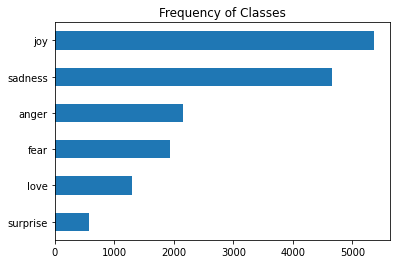

In [ ]:
# The dataset is imbalanced for the love/suprise classes.
# Randomly oversample the minority class.
# Randomly undersample the majority class.
# Gather more labeled data from the underespresetned classes.
df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


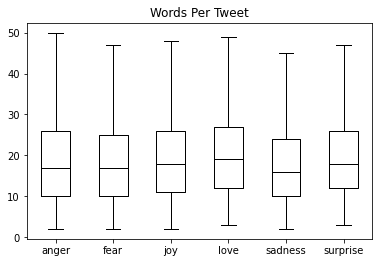

In [ ]:
# Most tweets are around 15 words long
# and the longest tweets are well below DistilBERT’s maximum context size of 512.
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False, showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [ ]:
# Reset back to the Dataset format.
emotions.reset_format()

### Tokenization
Transformers, RNNS expect that text has been tokenized and encoded as numerical vectors. Tokenization is the step of breaking down a string into the atomic units used in the model.

### Character tokenization

In [ ]:
# Character tokenization
text = "Tokenizing text is a core task of NLP."
tokenized_text = list(text)
print(tokenized_text)

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ', 'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o', 'f', ' ', 'N', 'L', 'P', '.']


In [ ]:
# Numericalization
# 1. Get unique items,
# 2. Sort the items
# 3. Enumerate
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
print(token2idx)

{' ': 0, '.': 1, 'L': 2, 'N': 3, 'P': 4, 'T': 5, 'a': 6, 'c': 7, 'e': 8, 'f': 9, 'g': 10, 'i': 11, 'k': 12, 'n': 13, 'o': 14, 'r': 15, 's': 16, 't': 17, 'x': 18, 'z': 19}


In [ ]:
input_ids = [token2idx[token] for token in tokenized_text]
print(input_ids)

[5, 14, 12, 8, 13, 11, 19, 11, 13, 10, 0, 17, 8, 18, 17, 0, 11, 16, 0, 6, 0, 7, 14, 15, 8, 0, 17, 6, 16, 12, 0, 14, 9, 0, 3, 2, 4, 1]


In [ ]:
# One hot encoding.
categorical_df = pd.DataFrame(
{"Name": ["Bumblebee", "Optimus Prime", "Megatron"], "Label": [0,1,2]})
categorical_df

,Name,Label
0,Bumblebee,0
1,Optimus Prime,1
2,Megatron,2


In [ ]:
pd.get_dummies(categorical_df["Name"])

,Bumblebee,Megatron,Optimus Prime
0,1,0,0
1,0,0,1
2,0,1,0


In [ ]:
len(token2idx), len(input_ids)

(20, 38)

In [ ]:
# Convert list to pytorch tensor.
input_ids = torch.tensor(input_ids)
one_hot_encodings = F.one_hot(input_ids, num_classes=len(token2idx))
one_hot_encodings.shape

torch.Size([38, 20])

In [ ]:
print(f"Token: {tokenized_text[0]}")
print(f"Tensor index: {input_ids[0]}")
print(f"One-hot: {one_hot_encodings[0]}")

Token: T
Tensor index: 5
One-hot: tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


Pros:
1. Works well with misspellings, rare words.

Cons:
1. Ignores any structure in the text.
1. Structure has to be learned from the data which is data and computationally intensive.

### Word Tokenization

In [ ]:
tokenized_text = text.split()
print(tokenized_text)

['Tokenizing', 'text', 'is', 'a', 'core', 'task', 'of', 'NLP.']


With word tokenization the weights can quickly explode just in the first layer of the network.

### Subword Tokenization
A compromise between character and word tokenization.

In [ ]:
# WordPiece
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [ ]:
distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)

In [ ]:
distilbert_tokenizer

PreTrainedTokenizer(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=False, padding_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [ ]:
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [ ]:
# Convert the input ids back to tokens.
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']


In [ ]:
text

'Tokenizing text is a core task of NLP.'

In [ ]:
print(tokenizer.vocab_size)
print(tokenizer.model_max_length)
print(tokenizer.model_input_names)

30522
512
['input_ids', 'attention_mask']


### Tokenizing the Whole Dataset

In [ ]:
def tokenize(batch):
  return tokenizer(batch["text"], padding=True, truncation=True)

In [ ]:
tokenize(emotions["train"][:2])

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [ ]:
# Encode the whole dataset.
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
emotions_encoded["train"]

Dataset({
    features: ['attention_mask', 'input_ids', 'label', 'text'],
    num_rows: 16000
})

### Training a Text Classifier
DistilBERT and the like are pretrained to predict masked words in a sequence of a text.
1. Text tokenization.
1. Create token encodings.
1. Create token embeddings (a lower-dimensional space of token encodings).
1. Token embeddings pass through the encoder block to yield a hidden state.

For classification task, the language modeling layer with a classification layer with two options.
1. `Feature extraction`: use hidden states as features and train a classifer on them without modifying the pretrained model.
1. `Fine-tuning`: train the model end-to-end which also updates the parameters of the pretrained model.

### Transformers as Feature Extractors
Freeze the body's weights during training and use the hideen states as features for the classifier.

In [ ]:
model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_ = AutoModel.from_pretrained(model_ckpt).to(device)

In [ ]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")

Input tensor shape: torch.Size([1, 6])


In [ ]:
print(inputs)
print(tokenizer.convert_ids_to_tokens(inputs["input_ids"].cpu().numpy()[0]))

{'input_ids': tensor([[ 101, 2023, 2003, 1037, 3231,  102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}
['[CLS]', 'this', 'is', 'a', 'test', '[SEP]']


In [ ]:
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
  outputs = model_(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [ ]:
outputs.last_hidden_state.size()

torch.Size([1, 6, 768])

In [ ]:
outputs.last_hidden_state[:, 0].size

<function Tensor.size>

In [ ]:
def extract_hidden_states(batch):
  # Place the module on the same device as the model.
  inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
  # Extract last hidden states.
  with torch.no_grad():
    last_hidden_state = model_(**inputs).last_hidden_state
  # Return vector for [CLS] token.
  return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [ ]:
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

In [ ]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

#### Creating a feature matrix

In [ ]:
X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

#### Visualizing the training set
Use the UMAP algorithm to project the vectors down to 2D. Expects the features with in the [0,1] interval.

In [ ]:
# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,4.874063,6.646900,0
1,-2.370260,6.102217,0
2,5.564994,3.069759,3
3,-1.944420,3.864203,2
4,-3.051155,4.216768,3


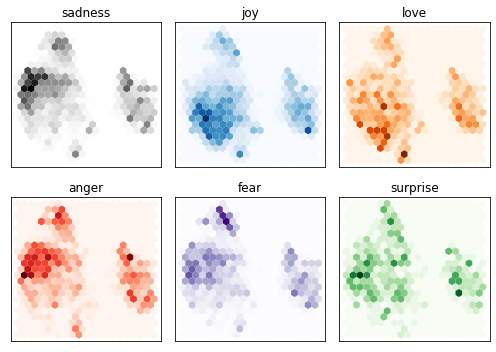

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
  df_emb_sub = df_emb.query(f"label == {i}")
  axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap, gridsize=20, linewidths=(0,))
  axes[i].set_title(label)
  axes[i].set_xticks([]), axes[i].set_yticks([])
plt.tight_layout()
plt.show()

#### Training a simple classifier
`sklearn.linear_model.LogisticRegression`

In [ ]:
lr_clf = LogisticRegression(max_iter=3000) # Max_iterations to increase convergence.
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.633

In [ ]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

In [ ]:
def plot_confusion_matrix(y_preds, y_true, labels):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(6,6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized confusion matrix")
  plt.show()

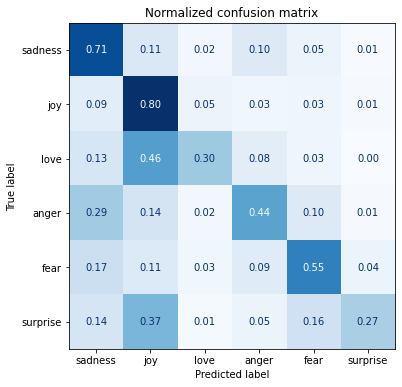

In [ ]:
y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

Confusion between anger and sadness, joy and love, suprise and joy.

### Fine-Tuning Transformers
#### Loading a pretrained model
Use AutoModelForSequenceClassification, instead of AutoModel, the prior has a classification head on top of the pretrained model outputs.

In [ ]:
num_labels = 6
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

In [ ]:
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average="weighted")
  acc = accuracy_score(labels, preds)
  return {"accuracy": acc, "f1": f1}

In [ ]:
# notebook_login()

#### Training the model

In [ ]:
# Set training arguments class.
batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False,
                                  log_level="error")
training_args

TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_find_unused_parameters=None,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_steps=None,
evaluation_strategy=IntervalStrategy.EPOCH,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
gradient_accumulation_steps=1,
gradient_checkpointing=False,
greater_is_better=None,
group_by_length=False,
hub_model_id=None,
hub_strategy=HubStrategy.EVERY_SAVE,
hub_token=<HUB_TOKEN>,
ignore_data_skip=False,
label_names=None,
label_smoothing_factor=0.0,
learning_rate=2e-05,
length_column_name=length,
load_best_model_at_end=False,
local_rank=-1,
log_level=40,
log_level_replica=-1,
log_on_each_node=True,
logging_dir=distilbert-base-uncased-finetuned-emotion/runs/Nov05_08-56-02_54a0b5f2da05,
logging_first_step=False,
loggi

In [ ]:
# Setup the trainer.
trainer = Trainer(
    model=model, 
    args=training_args, 
    compute_metrics=compute_metrics,
    train_dataset=emotions_encoded["train"],
    eval_dataset=emotions_encoded["validation"],
    # tokenizer=tokenizer
    )

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.808500,0.302019,0.905500,0.903057
2,0.241100,0.214357,0.927500,0.927599


TrainOutput(global_step=500, training_loss=0.5247851486206054, metrics={'train_runtime': 238.9311, 'train_samples_per_second': 133.93, 'train_steps_per_second': 2.093, 'total_flos': 720342861696000.0, 'train_loss': 0.5247851486206054, 'epoch': 2.0})

In [ ]:
preds_output = trainer.predict(emotions_encoded["validation"])
preds_output.metrics

{'test_loss': 0.21435657143592834,
 'test_accuracy': 0.9275,
 'test_f1': 0.9275991035276141,
 'test_runtime': 4.597,
 'test_samples_per_second': 435.071,
 'test_steps_per_second': 6.961}

In [ ]:
# np.argmax(preds_output.predictions[90, :])

3

In [ ]:
y_preds = np.argmax(preds_output.predictions, axis=1)

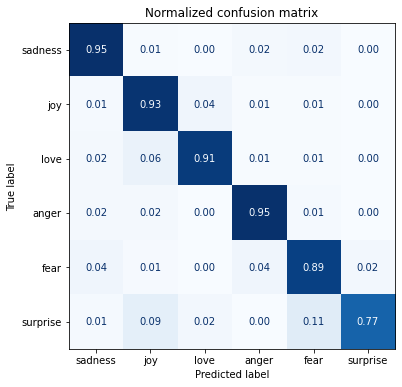

In [ ]:
plot_confusion_matrix(y_preds, y_valid, labels)

#### Error Analysis

In [ ]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

In [ ]:
def forward_pass_with_label(batch):
  # Place all input tensors on the same device as model.
  inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
  with torch.no_grad():
    output = model(**inputs)
    pred_label = torch.argmax(output.logits, axis=-1)
    loss = F.cross_entropy(output.logits, batch["label"].to(device),reduction="none")
  # Place outputs on CPU for compatibility with other dataset columns
  return {"loss": loss.cpu().numpy(), "predicted_label": pred_label.cpu().numpy()}  

In [ ]:
# Using the map() method once more, we can apply this function to get the losses for all
# the samples.
# Convert our dataset back to PyTorch tensors
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])
# Compute loss values
emotions_encoded["validation"] = emotions_encoded["validation"].map(forward_pass_with_label, batched=True, batch_size=16, load_from_cache_file=False)

  0%|          | 0/125 [00:00<?, ?ba/s]

In [ ]:
emotions_encoded

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'label', 'text'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['attention_mask', 'hidden_state', 'input_ids', 'label', 'loss', 'predicted_label', 'text'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'label', 'text'],
        num_rows: 2000
    })
})

In [ ]:
# create a DataFrame with the texts, losses, and predicted/true labels
emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(lambda row: emotions["train"].features["label"].int2str(row))
df_test["predicted_label"] = (df_test["predicted_label"].apply(lambda row: emotions["train"].features["label"].int2str(row)))

_Wrong labels_

Every process that adds labels to data can be flawed. Annotators can make mistakes
or disagree, while labels that are inferred from other features can be wrong.
If it was easy to automatically annotate data, then we would not need a model to
do it. Thus, it is normal that there are some wrongly labeled examples. With this approach, we can quickly find and correct them.

_Quirks of the dataset_

Datasets in the real world are always a bit messy. When working with text, special
characters or strings in the inputs can have a big impact on the model’s predictions.
Inspecting the model’s weakest predictions can help identify such features,
and cleaning the data or injecting similar examples can make the model more
robust.

In [ ]:
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
1382,i cannot even begin to express in words the de...,surprise,sadness,5.943340
290,i just feel are ludicrous and wasting space or...,surprise,sadness,5.748790
816,whenever i put myself in others shoes and try ...,anger,joy,5.641671
125,i feel very mislead by someone that i really r...,love,anger,5.194223
1253,i don t feel betrayed coz the backstabber had ...,surprise,sadness,5.060119
1270,i feel very saddened that the king whom i once...,joy,sadness,4.837246
1613,i feel very cheated since i am supporting the ...,joy,sadness,4.775184
1431,i felt a stronger wish to be free from self ch...,sadness,joy,4.701002
1533,i actually was in a meeting last week where so...,anger,sadness,4.384460
1020,i know is that she s here and i m so thankful ...,sadness,joy,4.179667


In [ ]:
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
1410,i am feeling joyful every part of me feels hap...,joy,joy,0.014887
956,i woke up very early this morning feeling joyful,joy,joy,0.015332
1105,im now on day two of the plan and im feeling p...,joy,joy,0.015550
116,i feel thoroughly virtuous even if the daily t...,joy,joy,0.015551
1316,i am pleased to report that i in many ways i a...,joy,joy,0.015567
547,i feel a little virtuous doing these things bu...,joy,joy,0.015652
1269,i like in this world and making a list of them...,joy,joy,0.015745
478,i feel complacent and satisfied,joy,joy,0.015774
672,i take a walk in the park feeling joyful,joy,joy,0.015799
1359,im feeling quite positive in what i want to ac...,joy,joy,0.015830


#### Saving and sharing the model

In [ ]:
trainer.push_to_hub(commit_message="Training completed")

Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file runs/Apr30_13-36-47_c951d3306044/events.out.tfevents.1651325841.c951d3306044.71.2:  72%|#######1  …

To https://huggingface.co/bomera/distilbert-base-uncased-finetuned-emotion
   de82af2..844b563  main -> main

To https://huggingface.co/bomera/distilbert-base-uncased-finetuned-emotion
   844b563..1b03f87  main -> main



'https://huggingface.co/bomera/distilbert-base-uncased-finetuned-emotion/commit/844b56349a15d6d3db4ed74a46cb4e230de6b4a2'

In [ ]:
# model_id = "bomera/distilbert-base-uncased-finetuned-emotion"
# classifier = pipeline("text-classification", model=model_id)